<a href="https://colab.research.google.com/github/thuthuynt/my_report/blob/master/Thuy_NYC_Taxi_2014_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:

# Colab library to upload files to notebook
from google.colab import files

# Install Kaggle library
!pip install -q kaggle

In [0]:
#Upload file kaggle.json (API credential) to use kaggel API
uploaded = files.upload()


Saving kaggle.json to kaggle.json


In [1]:
!ls

2014-new-york-city-taxi-trips.zip  nyc_taxi_data_2014.csv     sample_data
kaggle.json			   nyc_taxi_data_2014.csv.gz


In [0]:
!cp kaggle.json ~/.kaggle/kaggle.json

In [0]:
!kaggle datasets download -d kentonnlp/2014-new-york-city-taxi-trips

 99% 995M/0.98G [00:12<00:00, 114MB/s]
100% 0.98G/0.98G [00:12<00:00, 86.2MB/s]


In [0]:
!unzip 2014-new-york-city-taxi-trips.zip

Archive:  2014-new-york-city-taxi-trips.zip
  inflating: nyc_taxi_data_2014.csv  
  inflating: nyc_taxi_data_2014.csv.gz  


In [0]:
# Import Python Libraries
import numpy as np
import pandas as pd
import pandas_profiling

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys
import time
import requests
import datetime as dt


In [2]:
df = pd.read_csv("nyc_taxi_data_2014.csv")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
df.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
0,CMT,2014-01-09 20:45:25,2014-01-09 20:52:31,1,0.7,-73.994770,40.736828,1,N,-73.982227,40.731790,CRD,6.5,0.5,0.5,1.40,0.0,8.90
1,CMT,2014-01-09 20:46:12,2014-01-09 20:55:12,1,1.4,-73.982392,40.773382,1,N,-73.960449,40.763995,CRD,8.5,0.5,0.5,1.90,0.0,11.40
2,CMT,2014-01-09 20:44:47,2014-01-09 20:59:46,2,2.3,-73.988570,40.739406,1,N,-73.986626,40.765217,CRD,11.5,0.5,0.5,1.50,0.0,14.00
3,CMT,2014-01-09 20:44:57,2014-01-09 20:51:40,1,1.7,-73.960213,40.770464,1,N,-73.979863,40.777050,CRD,7.5,0.5,0.5,1.70,0.0,10.20
4,CMT,2014-01-09 20:47:09,2014-01-09 20:53:32,1,0.9,-73.995371,40.717248,1,N,-73.984367,40.720524,CRD,6.0,0.5,0.5,1.75,0.0,8.75


In [28]:
df.dtypes

vendor_id              object
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
trip_distance         float64
pickup_longitude      float64
pickup_latitude       float64
rate_code               int64
store_and_fwd_flag     object
dropoff_longitude     float64
dropoff_latitude      float64
payment_type           object
fare_amount           float64
surcharge             float64
mta_tax               float64
tip_amount            float64
tolls_amount          float64
total_amount          float64
dtype: object

In [29]:
df.describe()

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,dropoff_longitude,dropoff_latitude,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
count,1.500000e+07,1.500000e+07,1.500000e+07,1.500000e+07,1.500000e+07,1.499985e+07,1.499985e+07,1.500000e+07,1.500000e+07,1.500000e+07,1.500000e+07,1.500000e+07,1.500000e+07
mean,1.701826e+00,2.792074e+00,-7.296749e+01,4.019355e+01,1.033778e+00,-7.290756e+01,4.016132e+01,1.201335e+01,3.145898e-01,4.982227e-01,1.455907e+00,2.404203e-01,1.452348e+01
std,1.390736e+00,3.326122e+00,8.586309e+00,4.762641e+00,7.177268e-01,8.843060e+00,4.897983e+00,1.006726e+01,3.633407e-01,2.975721e-02,2.244646e+00,1.191025e+00,1.216687e+01
min,0.000000e+00,0.000000e+00,-7.366000e+02,-1.800000e+02,0.000000e+00,-7.754167e+02,-1.800000e+02,2.500000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.500000e+00
25%,1.000000e+00,1.000000e+00,-7.399198e+01,4.073535e+01,1.000000e+00,-7.399135e+01,4.073420e+01,6.500000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,8.000000e+00
50%,1.000000e+00,1.700000e+00,-7.398183e+01,4.075298e+01,1.000000e+00,-7.398007e+01,4.075337e+01,9.000000e+00,0.000000e+00,5.000000e-01,1.000000e+00,0.000000e+00,1.100000e+01
75%,2.000000e+00,3.080000e+00,-7.396735e+01,4.076724e+01,1.000000e+00,-7.396351e+01,4.076839e+01,1.350000e+01,5.000000e-01,5.000000e-01,2.000000e+00,0.000000e+00,1.610000e+01
max,2.080000e+02,1.000000e+02,8.054390e+01,7.328431e+01,2.100000e+02,1.193360e+02,4.040833e+02,5.000000e+02,1.340000e+01,5.000000e-01,2.000000e+02,2.000000e+01,7.000000e+02


In [8]:
df.isnull().sum()


vendor_id                   0
pickup_datetime             0
dropoff_datetime            0
passenger_count             0
trip_distance               0
pickup_longitude            0
pickup_latitude             0
rate_code                   0
store_and_fwd_flag    7636077
dropoff_longitude         145
dropoff_latitude          145
payment_type                0
fare_amount                 0
surcharge                   0
mta_tax                     0
tip_amount                  0
tolls_amount                0
total_amount                0
dtype: int64

In [9]:
df.passenger_count[df.dropoff_longitude.isnull()].unique()
#drop off lat/long is null <=> passenger_count = 0 => that was not a trip => should be drop


array([0])

In [0]:
df=df.dropna(subset=["dropoff_longitude"])
# dropna where drop off long/latitude are null 

In [33]:
df.shape


(14999854, 18)

In [0]:
df['pickup_datetime']=pd.to_datetime(df.pickup_datetime)
df['dropoff_datetime']=pd.to_datetime(df.dropoff_datetime)


In [0]:
df['trip_duration'] = df.dropoff_datetime - df.pickup_datetime
df.trip_duration=df.trip_duration.astype('timedelta64[s]')

In [0]:
df["pickup_dow"] = df.pickup_datetime.dt.dayofweek
df["pickup_weekday"] = df.pickup_datetime.dt.weekday_name
df["pickup_hour"] = df.pickup_datetime.dt.hour
df["pickup_month"] = df.pickup_datetime.dt.month
df["pickup_week"] = df.pickup_datetime.dt.week


**1 - OVERVIEW**
The first part is about following Trends:

1. Timerange of the dataset
2. Total trips taken per month, growth rate (MOM)
3. Total trips taken per week, growth rate (WOW)
4. Distribution of trips in a week

1.1 Timerange

In [37]:
print("Dataset start date: ", min(df.pickup_datetime))
print("Dataset end date: ", max(df.pickup_datetime))

Dataset start date:  2014-01-01 00:00:00
Dataset end date:  2014-02-28 23:59:00


1.2 Number of trips and the growth rate MOM

In [0]:
tab0=df.groupby(['pickup_month']).agg({'pickup_datetime':'count'}).rename(columns={"pickup_datetime":"number_trips"}).reset_index()

In [0]:
tab0["number_trips_lag"]=tab0.number_trips.shift(1)
tab0["growth_rate_MOM"] = (tab0.number_trips - tab0.number_trips_lag)/tab0.number_trips_lag*100

In [16]:
tab0

,pickup_month,number_trips,number_trips_lag,growth_rate_MOM
0,1,13782347,NaN,NaN
1,2,1217507,13782347.0,-91.166185


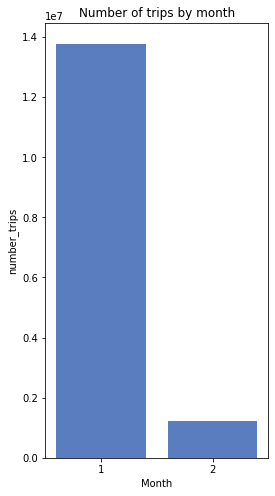

In [18]:
plt.figure(figsize=(4,8))
sns.set_color_codes("muted")
sns.barplot(x="pickup_month",y="number_trips", color="b", data=tab0.reset_index())
plt.title("Number of trips by month")
plt.xlabel("Month")
plt.ylabel=("Number of trips")
plt.show()

1.3 Number of trips by week and growth rate (WOW)

In [0]:
df['OrderPeriod'] = df.pickup_datetime.apply(lambda x: (x-dt.timedelta(x.weekday())).strftime('%Y-%m-%d'))

In [0]:
tab1=df.groupby(['OrderPeriod']).agg({'pickup_datetime':'count','total_amount':'count'}).rename(columns = {"pickup_datetime":"number_of_trips"}).reset_index()

In [0]:
tab1["number_of_trips_lag"]=tab1.number_of_trips.shift(1)
tab1["growth_rate_MOM"] = (tab1.number_of_trips - tab1.number_of_trips_lag)/tab1.number_of_trips_lag*100

[Text(0, 0.5, 'Growth Rate')]

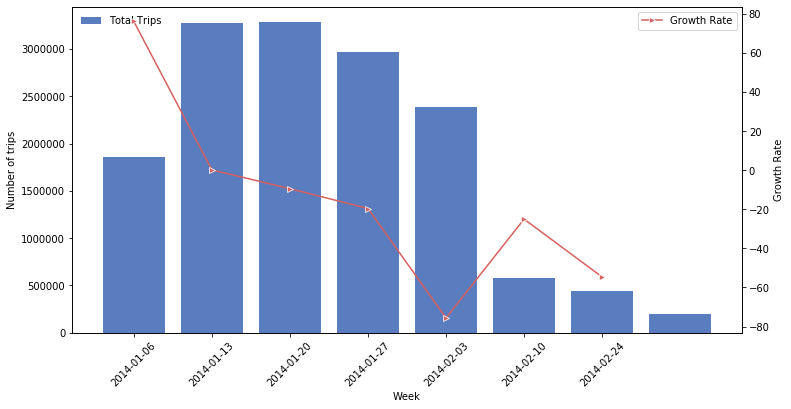

In [22]:
f,ax=plt.subplots(figsize=(12,6))
sns.set_color_codes("muted")
sns.barplot(x="OrderPeriod",y="number_of_trips",data=tab1,color="b",label="Total Trips")
ax.set_xticklabels(labels=tab1.OrderPeriod,rotation='45')
ax2=plt.twinx() 
sns.lineplot(x="OrderPeriod",y="growth_rate_MOM",data=tab1,color="r",ax=ax2,label="Growth Rate",marker='>')
ax.legend(loc="upper left",frameon=False)
ax2.legend(loc="upper right")
ax.set(xlabel="Week",ylabel="Number of trips")
ax2.set(ylabel="Growth Rate")

1.4. Distribution of trips in a week, by day of week

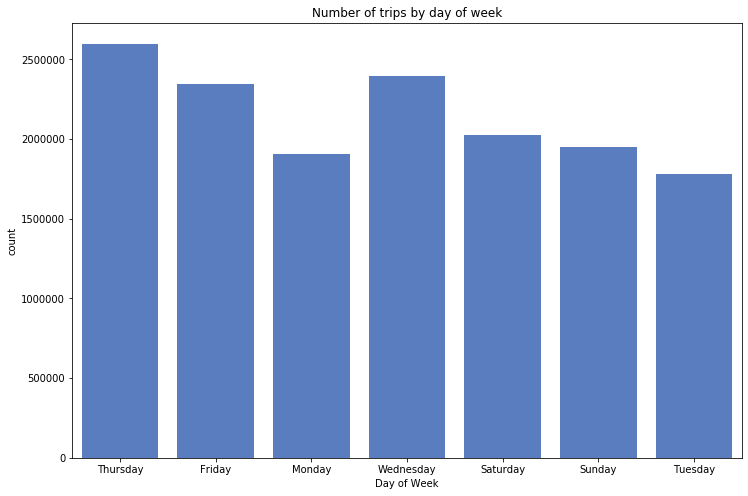

In [23]:
plt.figure(figsize=(12,8))
sns.set_color_codes("muted")
sns.countplot(x="pickup_weekday", color="b", data=df)
plt.title("Number of trips by day of week")
plt.xlabel("Day of Week")
plt.ylabel=("Number of trips")
plt.show()

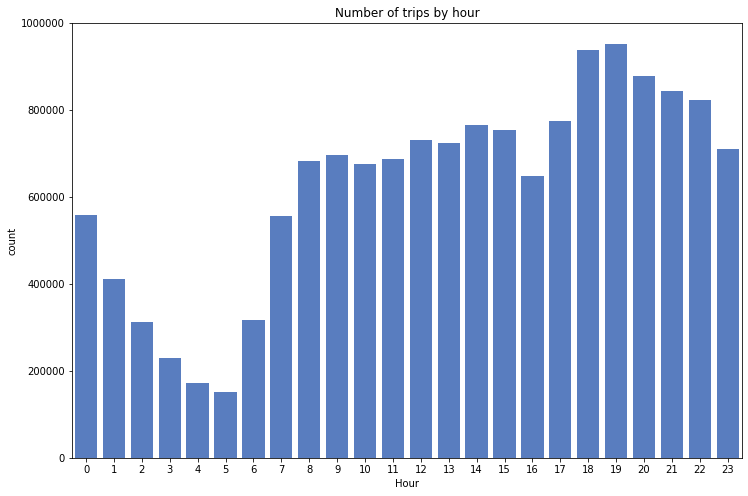

In [0]:
plt.figure(figsize=(12,8))
sns.set_color_codes("muted")
sns.countplot(x="pickup_hour", color="b", data=df)
plt.title("Number of trips by hour")
plt.xlabel("Hour")
plt.ylabel=("Number of trips")
plt.show()

**2. Trip Metrics in details**
1. Distribution of number passenger in a trip 
2. Trip Duration
3. Distance (m)
4. Rating
5. Speed
6. Tip amount


2.1 Distribution of number passenger in a trip 

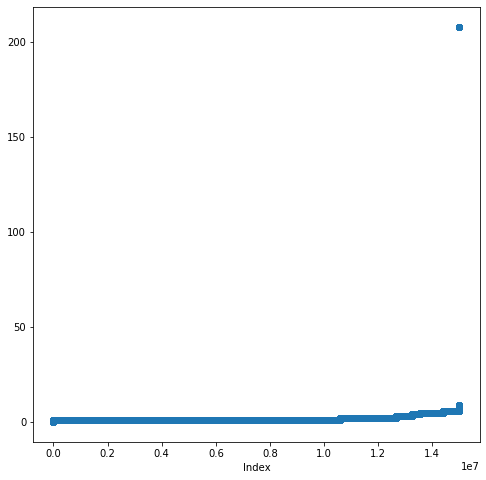

In [26]:
##Check outlier
plt.figure(figsize=(8,8))
plt.scatter(range(len(df["passenger_count"])), np.sort(df["passenger_count"]))
plt.xlabel("Index")
plt.ylabel=("Number of passenger")
plt.show()


In [0]:
#remove outliers
df = df[df["passenger_count"] < 50]

In [0]:
tab2 = df.groupby(['passenger_count']).agg({'pickup_datetime':'count'}).rename(columns = {"pickup_datetime":"number_of_trips"}).reset_index()

In [29]:
tab2

,passenger_count,number_of_trips
0,0,124
1,1,10602705
2,2,2046972
3,3,611904
4,4,288702
5,5,860368
6,6,589030
7,7,7
8,8,5
9,9,18


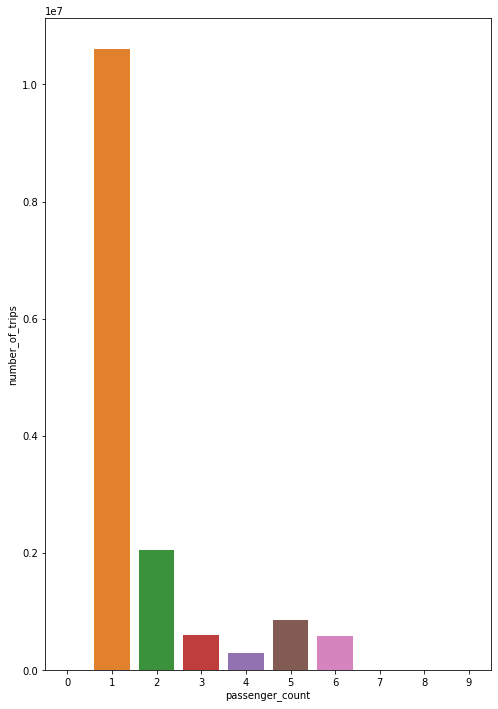

In [0]:
plt.figure(figsize=(8,12))
sns.set_color_codes("muted")
sns.barplot(x="passenger_count", y="number_of_trips",data=tab2)
plt.show()


2.2 Trip duration

In [7]:
df["trip_duration"].describe()


count    1.499985e+07
mean     7.392209e+02
std      1.053395e+03
min     -1.131618e+06
25%      3.600000e+02
50%      6.000000e+02
75%      9.600000e+02
max      1.171038e+06
Name: trip_duration, dtype: float64

In [8]:
(df["dropoff_datetime"] - df["pickup_datetime"]).describe()
#There are outliers in trip_duration. Trip_duration must be greater than 0 and greater than (a) day(s)
)

count                  14999854
mean     0 days 00:12:19.220861
std      0 days 00:17:33.394750
min          -14 days +21:39:42
25%             0 days 00:06:00
50%             0 days 00:10:00
75%             0 days 00:16:00
max            13 days 13:17:18
dtype: object

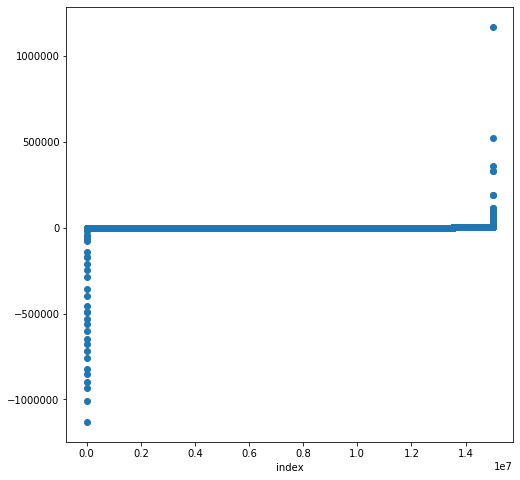

In [9]:
##Check outlier
plt.figure(figsize=(8,8))
plt.scatter(range(len(df["trip_duration"])), np.sort(df["trip_duration"]))
plt.xlabel('index')
plt.ylabel=('trip_duration in seconds')
plt.show()


In [0]:
#Remove outlier
df = df[(df.trip_duration < 150000) & (df.trip_duration > 0)]

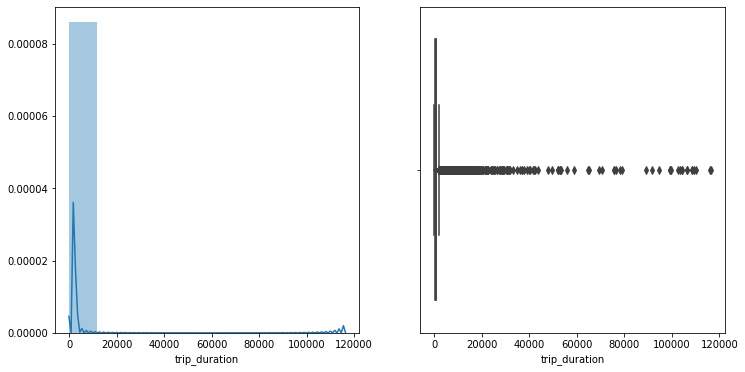

In [13]:
#visualize trip_duration distribution
f, ax=plt.subplots(1,2,figsize=(12,6))
ax1=ax[0] 
sns.distplot(df.trip_duration,bins=10,ax=ax1)
ax2=ax[1]
sns.boxplot(df.trip_duration,ax=ax2)

In [14]:
(df["dropoff_datetime"] - df["pickup_datetime"]).describe()


count                  14957341
mean     0 days 00:12:22.042145
std      0 days 00:09:37.917242
min             0 days 00:00:01
25%             0 days 00:06:00
50%             0 days 00:10:00
75%             0 days 00:16:00
max             1 days 08:19:28
dtype: object

2.3 Distance

In [15]:
df["trip_distance"].describe()


count    1.495734e+07
mean     2.799215e+00
std      3.326339e+00
min      0.000000e+00
25%      1.000000e+00
50%      1.700000e+00
75%      3.090000e+00
max      1.000000e+02
Name: trip_distance, dtype: float64

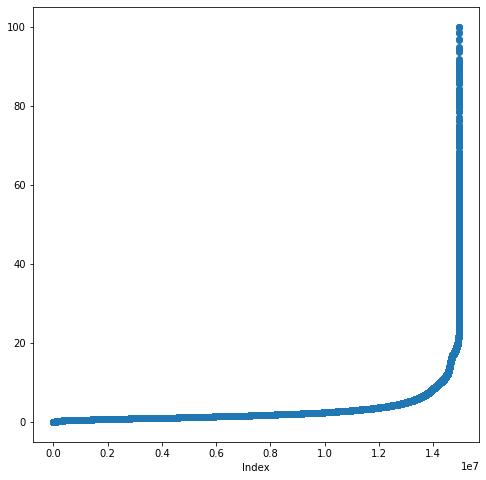

In [18]:
##Check outlier
plt.figure(figsize=(8,8))
plt.scatter(range(len(df["trip_distance"])), np.sort(df["trip_distance"]))
plt.xlabel('Index')
plt.ylabel=('Trip_distance')
plt.show()


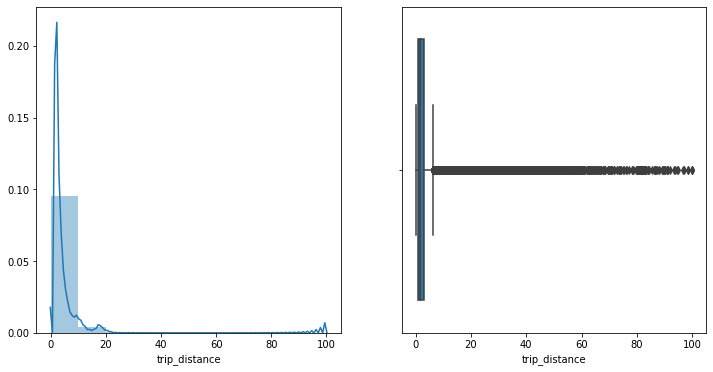

In [17]:
f, ax=plt.subplots(1,2,figsize=(12,6))
ax1=ax[0] 
sns.distplot(df.trip_distance,bins=10,ax=ax1)
ax2=ax[1]
sns.boxplot(df.trip_distance,ax=ax2)

2.4 Rating


In [19]:
df["rate_code"].describe()


count    1.495734e+07
mean     1.030226e+00
std      7.094052e-01
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      2.100000e+02
Name: rate_code, dtype: float64

In [0]:
tab3 = df.groupby(['rate_code']).agg({'pickup_datetime':'count', 'tip_amount':'mean'}).rename(columns = {"pickup_datetime":"number_of_trips"}).reset_index()

In [21]:
tab3

,rate_code,number_of_trips,tip_amount
0,0,1170,0.126829
1,1,14656196,1.340197
2,2,243671,6.680492
3,3,21146,8.684663
4,4,4932,5.792634
5,5,29902,7.637035
6,6,144,0.746528
7,7,3,0.000000
8,8,21,0.000000
9,9,2,1.500000


In [0]:
#remove outliers
tab3 = tab3[tab3.rate_code < 28]

In [23]:
#log transformation
tab3['log_number_of_trips'] = np.log(tab3.number_of_trips+1)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


[Text(0, 0.5, 'Avg Tip Amount')]

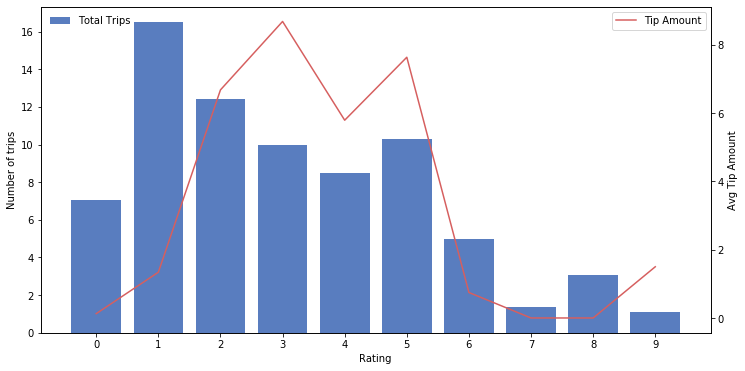

In [24]:
f,ax=plt.subplots(figsize=(12,6))
sns.set_color_codes("muted")
sns.barplot(x="rate_code",y="log_number_of_trips",data=tab3,color="b",label="Total Trips")
ax2=plt.twinx() 
sns.lineplot(x="rate_code",y="tip_amount",data=tab3,color="r",ax=ax2,label="Tip Amount")
ax.legend(loc="upper left",frameon=False)
ax2.legend(loc="upper right")
ax.set(xlabel="Rating",ylabel="Number of trips")
ax2.set(ylabel="Avg Tip Amount")

[Text(0, 0.5, 'Avg Tip Amount')]

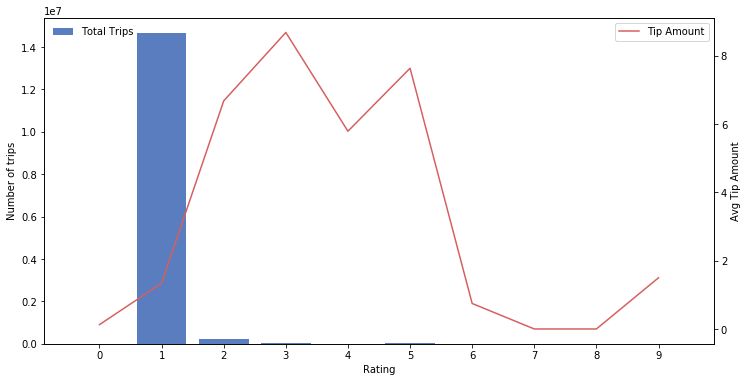

In [0]:
# f,ax=plt.subplots(figsize=(12,6))
# sns.set_color_codes("muted")
# sns.barplot(x="rate_code",y="number_of_trips",data=tab3,color="b",label="Total Trips")
# ax2=plt.twinx() 
# sns.lineplot(x="rate_code",y="tip_amount",data=tab3,color="r",ax=ax2,label="Tip Amount")
# ax.legend(loc="upper left",frameon=False)
# ax2.legend(loc="upper right")
# ax.set(xlabel="Rating",ylabel="Number of trips")
# ax2.set(ylabel="Avg Tip Amount")

2.5. Speed

In [0]:
df['speed'] = df.trip_distance/df.trip_duration*3600
#mph 

In [0]:
df.speed.head()

0    0.005915
1    0.009333
2    0.009210
3    0.015186
4    0.008460
Name: speed, dtype: float64

In [0]:
df['speed'].max()

83880.0

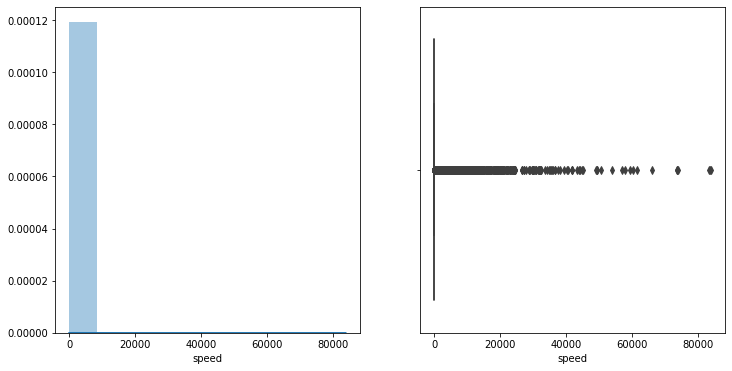

In [0]:
f, ax=plt.subplots(1,2,figsize=(12,6))
ax1=ax[0] 
sns.distplot(df.speed,bins=10,ax=ax1)
ax2=ax[1]
sns.boxplot(df.speed,ax=ax2)

2.6 Tip amount

In [0]:
df.tip_amount.describe()

count    1.495734e+07
mean     1.451546e+00
std      2.212412e+00
min      0.000000e+00
25%      0.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      2.000000e+02
Name: tip_amount, dtype: float64

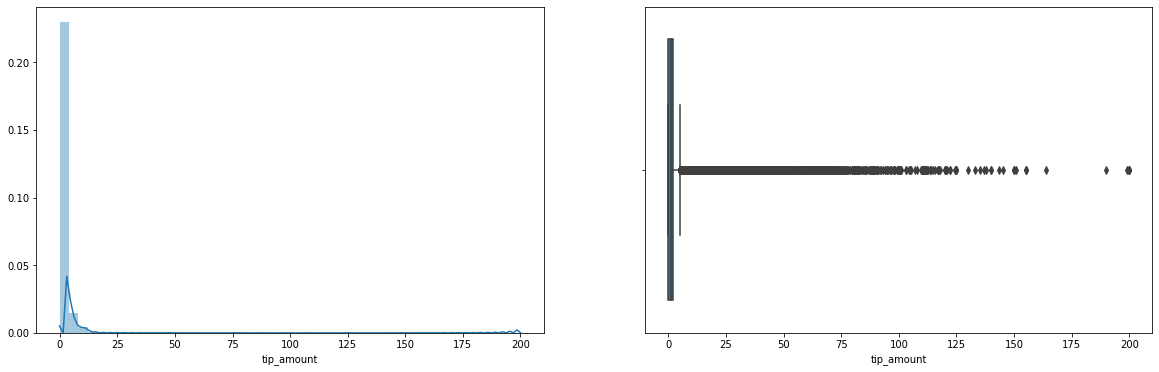

In [26]:
f, ax=plt.subplots(1,2,figsize=(20,6))
ax1=ax[0] 
sns.distplot(df.tip_amount,bins=50,ax=ax1)
ax2=ax[1]
sns.boxplot(df.tip_amount,ax=ax2)

In [0]:
df['tip_percentage'] = df.tip_amount/df.total_amount

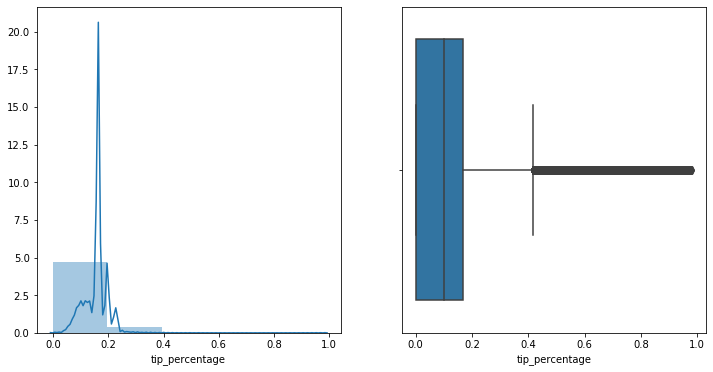

In [0]:
f, ax=plt.subplots(1,2,figsize=(12,6))
ax1=ax[0] 
sns.distplot(df.tip_percentage,bins=10,ax=ax1)
ax2=ax[1]
sns.boxplot(df.tip_percentage,ax=ax2)